In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


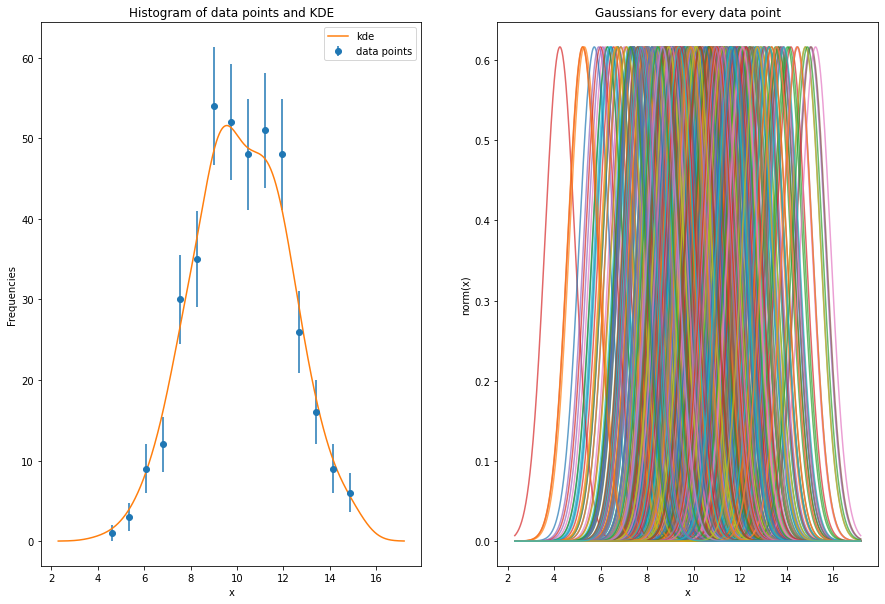

In [31]:
data = np.random.normal(loc=10,scale=2,size=400)
n, bin_edges= np.histogram(data, 15)
pos = 0.5*(bin_edges[1:] + bin_edges[:-1])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.errorbar(pos,n,yerr=np.sqrt(n),fmt='o', label="data points")
ax1.set_xlabel("x")
ax1.set_ylabel("Frequencies")
ax1.set_title("Histogram of data points and KDE")

gaus_list = list()
std_def = 1.06*data.std()*data.size**(-0.2)
plot_range = np.linspace(data.min()-3*std_def,data.max()+3*std_def,1000)

for i,x in enumerate(data):
    gaus_list.append(sp.stats.norm(loc=x,scale=std_def).pdf(plot_range))
    ax2.plot(plot_range,gaus_list[i],alpha=0.7)

gaus_list = np.array(gaus_list)

ax2.set_title("Gaussians for every data point")
ax2.set_xlabel('x')
ax2.set_ylabel('norm(x)')

area = sp.integrate.trapz(n,dx=bin_edges[1]-bin_edges[0])
kde = np.sum(gaus_list,axis=0)
kde *= area/sp.integrate.trapz(kde,dx=plot_range[1]-plot_range[0])
ax1.plot(plot_range, kde, label='kde')
ax1.legend();



2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

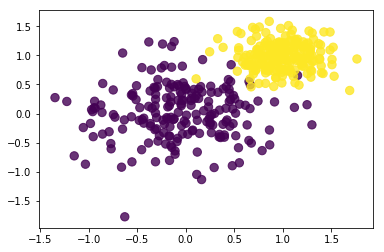

In [3]:
# ! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

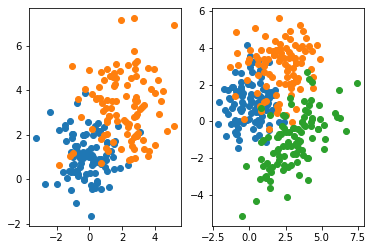

In [4]:
def gen_2D_dataset(n,size,mean,cov):
    datasets = []
    for i in range(n):
        datasets.append(np.random.multivariate_normal(mean=mean[i],cov=cov[i],size=size))
    return np.array(datasets)

data = gen_2D_dataset(2,100,[[0,1],[2,3]],[[[1,0],[0,1]],[[2,0],[0,2]]])
fig, (ax1, ax2) = plt.subplots(1,2)
for i in data:
    ax1.scatter(i[:,0], i[:,1])

#with 3 but works with n categories 
data2 = gen_2D_dataset(3,100,[[0,1],[2,3],[3,-1]],[[[1,0],[0,1]],[[2,0],[0,2]],[[2,1],[1,2]]])
for i in data2:
    ax2.scatter(i[:,0], i[:,1])


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

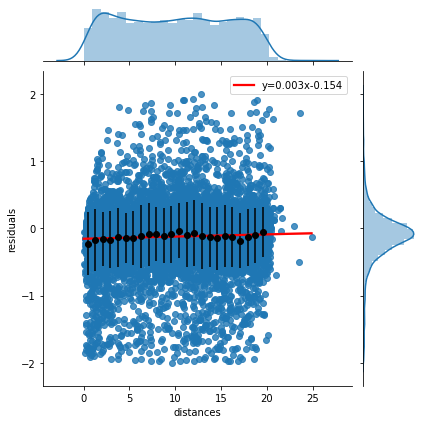

In [5]:
try:
    data = pd.DataFrame(np.load("residuals_261.npy",allow_pickle=True).item())
except:
    !wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
    data = pd.DataFrame(np.load("residuals_261.npy",allow_pickle=True).item())

data.head()
data = data[np.fabs(data["residuals"])<2]
slope, intercept, rvalue, pvalue, stderr = sp.stats.linregress(data["distances"],data["residuals"])

g1 = sns.jointplot(data["distances"],data["residuals"], kind='reg',joint_kws={'line_kws':{'color':'red','label':"y={0:.3f}x{1:+.3f}".format(slope,intercept)}})
g1.ax_joint.legend()


x_edges=np.linspace(0,20,25)
x = 0.5*(x_edges[1:]+x_edges[:-1])
y = np.array([np.mean(data[(data["distances"]>x_edges[i]) & (data["distances"]<x_edges[i+1])]["residuals"]) for i in range(0,len(x_edges)-1)])
erry = np.array([np.std(data[(data["distances"]>x_edges[i]) & (data["distances"]<x_edges[i+1])]["residuals"]) for i in range(0,len(x_edges)-1)])

g1.x = x
g1.y = y
g1.plot_joint(plt.errorbar,yerr=erry, c='black', fmt='o');